### Importing Necessary Libraries

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

### Preparing the Dataset

In [5]:
folder_path = "/content/drive/MyDrive/Lung cancer detection/train"
sub_folders = sorted(os.listdir(folder_path))

image_paths = []
image_labels = []
image_classes = []

for label, sub_folder in enumerate(sub_folders):
    sub_folder_path = os.path.join(folder_path, sub_folder)
    image_classes.append(sub_folder)

    for img in os.listdir(sub_folder_path):
      if img.lower().endswith(('.png', '.jpg', '.jpeg')):
        img_path = os.path.join(sub_folder_path, img)
        image_paths.append(img_path)
        image_labels.append(label)

image_paths = np.array(image_paths)
image_labels = np.array(image_labels)
image_classes = np.array(image_classes)

## Data Info

In [3]:
no_of_img = len(image_paths)
print(f"Total number of images: {no_of_img}")

no_of_classes = len(np.unique(image_labels))
print(f"Total number of classes: {no_of_classes}")

Total number of images: 612
Total number of classes: 4


In [6]:
print("Classes:" , image_classes)

Classes: ['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib'
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa' 'normal'
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']


In [9]:
unique_classes, counts = np.unique(image_labels, return_counts=True)

for cls, count in zip(unique_classes, counts):
    print(f"{image_classes[cls]}: {count} ")

adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib: 194 
large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa: 115 
normal: 148 
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa: 155 


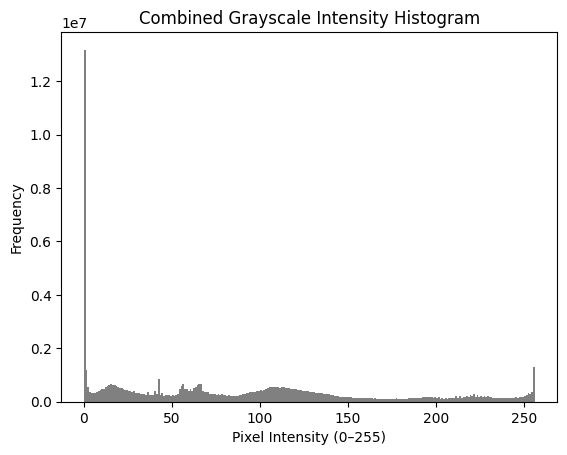

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

all_pixels = []

for img_path in image_paths:
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        all_pixels.extend(img.flatten())

all_pixels = np.array(all_pixels)

plt.hist(all_pixels, bins=256, range=(0, 256), color='gray')
plt.title("Combined Grayscale Intensity Histogram")
plt.xlabel("Pixel Intensity (0–255)")
plt.ylabel("Frequency")
plt.show()


### Data Preprocessing

In [ ]:
# We do this to increase the randomness of data
data_alteration = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.05),
    tf.keras.layers.RandomContrast(0.05),
])

def pixel_standardization(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=1) # our's is grayscale img

    img = tf.image.resize(img, (256, 256))
    img = img/255.0

    return img,label

def create_dataset(paths, labels, batch_siz = 16, is_traindata = False):
  Data = tf.data.Dataset.from_tensor_slices((paths, labels))

  if is_traindata:
    Data = Data.shuffle(buffer_size = len(paths), seed = 14)

  Data = Data.map(pixel_standardization, num_parallel_calls=tf.data.AUTOTUNE)

  if is_traindata:
    Data = Data.map(lambda x, y: (data_alteration(x), y), num_parallel_calls=tf.data.AUTOTUNE)

  Data = Data.batch(batch_siz).prefetch(tf.data.AUTOTUNE)
  return Data

### Building the Model

In [ ]:
def build_model() :
  model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(256, 256, 1)),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(4, activation='softmax')  # 4 output classes
    ])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0004),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  return model

### Preparing the final model

In [ ]:
train_data = create_dataset(image_paths, image_labels, is_traindata=True)
model = build_model()
history = model.fit(train_data, epochs = 50, verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.3985 - loss: 1.3155
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.6014 - loss: 0.9358
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.6484 - loss: 0.8577
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.7261 - loss: 0.6885
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.7170 - loss: 0.6265
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.7304 - loss: 0.6484
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.7752 - loss: 0.5295
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.8107 - loss: 0.4230
Epoch 9/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.8278 - loss: 0.4269
Epoch 10/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.8273 - loss: 0.3860
Epoch 11/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.8542 - loss: 0.3931
Epoch 12/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.84

### Visualising loss over epochs


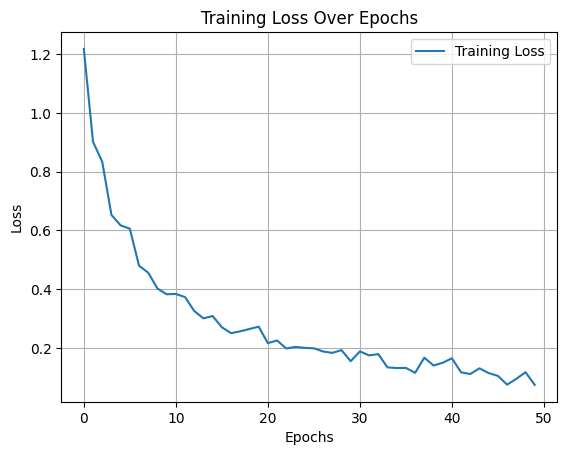

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

### Testing the model


In [ ]:
test_dir = "/content/drive/MyDrive/Lung cancer detection/valid"
test_image_paths = []
test_labels = []
test_class_names = sorted(os.listdir(test_dir))

for label_idx, class_name in enumerate(test_class_names):
    class_folder = os.path.join(test_dir, class_name)
    for fname in os.listdir(class_folder):
      if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
          test_image_paths.append(os.path.join(class_folder, fname))
          test_labels.append(label_idx)

test_image_paths = np.array(test_image_paths)
test_labels = np.array(test_labels)

ds_test = create_dataset(test_image_paths, test_labels, is_traindata=False)

test_probs = model.predict(ds_test)
test_preds = np.argmax(test_probs, axis=1)

from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(test_labels, test_preds)
print("Confusion Matrix:\n", cm)

report = classification_report(test_labels, test_preds, target_names=test_class_names)
print("Classification Report:\n", report)

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 630ms/step
Confusion Matrix:
 [[19  1  0  3]
 [ 5 15  0  1]
 [ 0  1 12  0]
 [ 1  0  0 14]]
Classification Report:
                                                   precision    recall  f1-score   support

      adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib       0.76      0.83      0.79        23
   large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa       0.88      0.71      0.79        21
                                          normal       1.00      0.92      0.96        13
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa       0.78      0.93      0.85        15

                                        accuracy                           0.83        72
                                       macro avg       0.86      0.85      0.85        72
                                    weighted avg       0.84      0.83      0.83        72



## Finalise the model

In [ ]:
model.save('lcd.keras')